# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import math
import json
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [2]:
print(portfolio.shape)
portfolio

(10, 6)


,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


In [3]:
print(profile.shape)
profile.head()

(17000, 5)


,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [4]:
print(transcript.shape)
transcript.head()

(306534, 4)


,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


## Clean portfolio dataframe

In [5]:
def clean_portfolio_df(df):
    df = df.copy()
    # convert channels column to dummies
    df['web'] = df['channels'].apply(lambda x: 1 if 'web' in x else 0)
    df['email'] = df['channels'].apply(lambda x: 1 if 'email' in x else 0)
    df['mobile'] = df['channels'].apply(lambda x: 1 if 'mobile' in x else 0)
    df['social'] = df['channels'].apply(lambda x: 1 if 'social' in x else 0)
    df = df.drop(columns='channels')
    # convert offer_type to dummies
    df = pd.get_dummies(df, columns=['offer_type'])
    # change name of reward column because I use this name in transcript df
    df = df.rename(columns={'reward': 'offer_reward'})
    # make id the index
    df = df.set_index('id')
    return df

In [6]:
portfolio

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


In [7]:
clean_portfolio_df(portfolio).head()

,offer_reward,difficulty,duration,web,email,mobile,social,offer_type_bogo,offer_type_discount,offer_type_informational
id,,,,,,,,,,
ae264e3637204a6fb9bb56bc8210ddfd,10,10,7,0,1,1,1,1,0,0
4d5c57ea9a6940dd891ad53e9dbe8da0,10,10,5,1,1,1,1,1,0,0
3f207df678b143eea3cee63160fa8bed,0,0,4,1,1,1,0,0,0,1
9b98b8c7a33c4b65b9aebfe6a799e6d9,5,5,7,1,1,1,0,1,0,0
0b1e1539f2cc45b7b9fa7c272da2e1d7,5,20,10,1,1,0,0,0,1,0


In [8]:
clean_portfolio_df(portfolio).columns

Index(['offer_reward', 'difficulty', 'duration', 'web', 'email', 'mobile',
       'social', 'offer_type_bogo', 'offer_type_discount',
       'offer_type_informational'],
      dtype='object')

## Clean profile dataframe

In [9]:
def clean_profile_df(df):
    df = df.copy()
    # missing age values are coded as 118; recode as NaN
    df['age'] = df['age'].replace([118], [np.nan])
    # recode date values as datetime
    df['became_member_on'] = df['became_member_on'].astype(str)
    df['became_member_on'] = pd.to_datetime(df['became_member_on'], format='%Y%m%d') - pd.datetime(1970,1,1)
    df['became_member_on'] = df['became_member_on'].apply(lambda x: x.days)
    # recode gender to dummies
    df1 = pd.get_dummies(df, columns=['gender'])
    df1.loc[df.gender.isnull(), df1.columns.str.startswith("gender_")] = np.nan
    df = df1.set_index('id')
    return df

In [10]:
profile_df = clean_profile_df(profile)
print(f'duplicates in profile df: {profile_df.duplicated().sum()}')
print()
print('missing values in profile df:')
profile_df.isna().sum()

duplicates in profile df: 1237

missing values in profile df:


age                 2175
became_member_on       0
income              2175
gender_F            2175
gender_M            2175
gender_O            2175
dtype: int64

In [11]:
profile_df.head()

,age,became_member_on,income,gender_F,gender_M,gender_O
id,,,,,,
68be06ca386d4c31939f3a4f0e3dd783,NaN,17209,NaN,NaN,NaN,NaN
0610b486422d4921ae7d2bf64640c50b,55.0,17362,112000.0,1.0,0.0,0.0
38fe809add3b4fcf9315a9694bb96ff5,NaN,17724,NaN,NaN,NaN,NaN
78afa995795e4d85b5d9ceeca43f5fef,75.0,17295,100000.0,1.0,0.0,0.0
a03223e636434f42ac4c3df47e8bac43,NaN,17382,NaN,NaN,NaN,NaN


## Explore transcript dataframe

[  0 168 336 408 504 576]


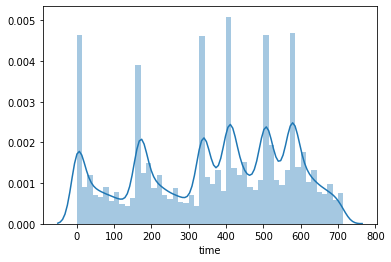

In [12]:
sns.distplot(transcript.time)
starts = transcript[transcript.event == 'offer received'].time.unique()
print(transcript[transcript.event == 'offer received'].time.unique())

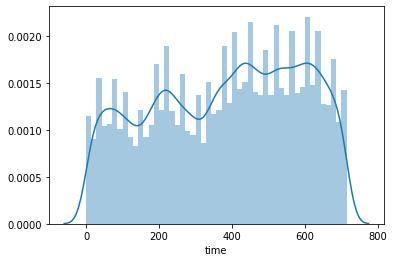

In [13]:
# it looks like there is a correlation between offer receipt and transactions
sns.distplot(transcript[transcript.event == 'transaction'].time)

In [14]:
# time is in six hour periods
# people receive offers at midnight
transcript.time.unique()

array([  0,   6,  12,  18,  24,  30,  36,  42,  48,  54,  60,  66,  72,
        78,  84,  90,  96, 102, 108, 114, 120, 126, 132, 138, 144, 150,
       156, 162, 168, 174, 180, 186, 192, 198, 204, 210, 216, 222, 228,
       234, 240, 246, 252, 258, 264, 270, 276, 282, 288, 294, 300, 306,
       312, 318, 324, 330, 336, 342, 348, 354, 360, 366, 372, 378, 384,
       390, 396, 402, 408, 414, 420, 426, 432, 438, 444, 450, 456, 462,
       468, 474, 480, 486, 492, 498, 504, 510, 516, 522, 528, 534, 540,
       546, 552, 558, 564, 570, 576, 582, 588, 594, 600, 606, 612, 618,
       624, 630, 636, 642, 648, 654, 660, 666, 672, 678, 684, 690, 696,
       702, 708, 714], dtype=int64)

In [15]:
336/24

14.0

In [16]:
len(transcript.time.unique())

120

In [17]:
profile_df.shape[0] / 30

566.6666666666666

## Make Panel Dataset

#### Discussion

##### Data
I am pooling data into one-day time periods.

##### Causal inference
I am making each experiment into a time period and analyzing the experiments as panel data. This allows me to approaches like fixed effects, and in general allows me to take advantage of variation across experiments rather than simple focusing on variation within them. Importantly, this allows me to take advantage of big-N small-T asymptotics. I don't know enough about time series analysis to approach this problem differently. What I know about splines, kernels, and kernel-based (local) regression methods suggests I would have problems with dimensionality were I to use them.

As of right now, I haven't checked to see if I can presume random assignment. I also need to see if every person receives an offer in each experiment. If they do not receive offers in every experiment, I have a no-treatment control group. If I have RA with a control group, the problem is a simple matter of linear regression (if RA process is perfect). If I have RA without a control group, I would take the same approach but the interpretation would change. If I do not have RA but do have a control group, I should do difference-in-differences. If I have no RA and no control group, causality is less certain and the interpretation is a comparison of treatments.

In general, it would be ideal for me to report results from multiple models. One model is OLS without FE, another model is OLS with person and time FE. I will cluster standard errors by person either way. Regardless of the situation, both approaches are important because FE precludes covariates that are constant over time. We need those variables to estimate heterogeneous effects. Still, one advantage of FE is that we can include customers who have missing values in all of their profile characteristics.

Note that person FE account for the innate features the Starbucks person described, and time FE accounts for differences in experiment implementation such as the number of days since the prior wave of offers was issued.


##### Prediction
After the causal inference analysis described above, I will use prediction methods that allow for arbitrary nonlinearity. I'm not sure yet how I will approach this. 

I can try to estimate latent variables using PCA. That would allow me to incorporate concepts like total transaction amount outside of experiment timeframes or over the course of the entire multi-year period. I would also like to cluster people into different spending trajectories. I forget the name of the method commonly used to do that, but I can find out.

In [18]:
transcript.time.unique()

array([  0,   6,  12,  18,  24,  30,  36,  42,  48,  54,  60,  66,  72,
        78,  84,  90,  96, 102, 108, 114, 120, 126, 132, 138, 144, 150,
       156, 162, 168, 174, 180, 186, 192, 198, 204, 210, 216, 222, 228,
       234, 240, 246, 252, 258, 264, 270, 276, 282, 288, 294, 300, 306,
       312, 318, 324, 330, 336, 342, 348, 354, 360, 366, 372, 378, 384,
       390, 396, 402, 408, 414, 420, 426, 432, 438, 444, 450, 456, 462,
       468, 474, 480, 486, 492, 498, 504, 510, 516, 522, 528, 534, 540,
       546, 552, 558, 564, 570, 576, 582, 588, 594, 600, 606, 612, 618,
       624, 630, 636, 642, 648, 654, 660, 666, 672, 678, 684, 690, 696,
       702, 708, 714], dtype=int64)

In [19]:
transcript.time.unique()[np.where(transcript.time.unique() % 24 == 0)]

array([  0,  24,  48,  72,  96, 120, 144, 168, 192, 216, 240, 264, 288,
       312, 336, 360, 384, 408, 432, 456, 480, 504, 528, 552, 576, 600,
       624, 648, 672, 696], dtype=int64)

In [ ]:
def make_system(people, times):
    result = pd.DataFrame()
    for person in people:
        person_t = np.full(shape=len(times), fill_value=person, dtype=object)
        N_T = pd.DataFrame({'person': person_t, 'time': times})
        result = result.append(N_T)
    result = result.reset_index(drop=True)
    return result

In [ ]:
panel_system = make_system(transcript.person.unique(), transcript.time.unique())
panel_system.to_csv('data/panel_system')

In [5]:
def make_panel_dataset(panels, transcript_df, profile_df):
    
    profile_df = clean_profile_df(profile_df)

    # format/split value column into columns that describe events
    transcript_df['offer_id'] = transcript_df['value'].apply(lambda x: x.get('offer id', np.nan))
    transcript_df['amount'] = transcript_df['value'].apply(lambda x: x.get('amount', 0))
    transcript_df['reward'] = transcript_df['value'].apply(lambda x: x.get('reward', 0))
    transcript_df = transcript_df.drop(columns='value')
    
   # convert offer and event columns to dummies
    transcript_df = pd.get_dummies(transcript_df, columns=['event'])
    
    # split transcript events into separate dataframes
    receipts = transcript_df[transcript_df['event_offer received']==1]
    receipts = receipts.drop(columns=['event_offer viewed', 'event_offer completed', 'event_transaction', 
                                      'amount', 'reward'])
    receipts = receipts.rename(columns={'offer_id': 'offered', 'event_offer received': 'offer_received'})
    receipts = pd.get_dummies(receipts, columns=['offered'])
    
    views = transcript_df[transcript_df['event_offer viewed']==1]
    views = views.drop(columns=['event_offer received', 'event_offer completed', 'event_transaction', 
                                'amount', 'reward'])
    views = views.rename(columns={'offer_id': 'viewed', 'event_offer viewed': 'offer_viewed'})
    views = pd.get_dummies(views, columns=['viewed'])
    
    completions = transcript_df[transcript_df['event_offer completed']==1]
    completions = completions.drop(columns=['event_offer received', 'event_offer viewed', 'event_transaction', 
                                            'amount', 'offer_id', 'reward'])
    completions = completions.rename(columns={'event_offer completed': 'offer_completed'})
    
    # merge transcript to panels
    panels = panels.merge(receipts, on=['person', 'time'], how='left')
    panels = panels.merge(views, on=['person', 'time'], how='left')
    panels = panels.merge(completions, on=['person', 'time'], how='left')
    
    # adjust missing values to reflect treatment assignment
    for person in panels.person.unique():
        panels.loc[panels.person==person, :] = panels.loc[panels.person==person, :].fillna(method='ffill')
    panels = panels.fillna(0)
    
    # now bring in offer rewards and transactions
    rewards = transcript_df[transcript_df['event_offer completed']==1]
    rewards = rewards.drop(columns=['event_offer received', 'event_offer viewed', 'event_transaction', 
                                    'amount', 'offer_id', 'event_offer completed'])
    transactions = transcript_df[transcript_df['event_transaction']==1]
    transactions = transactions.drop(columns=['event_offer received', 'event_offer viewed', 'event_transaction',
                                              'reward', 'offer_id', 'event_offer completed'])
    
    panels = panels.merge(rewards, on=['person', 'time'], how='left')
    panels = panels.merge(transactions, on=['person', 'time'], how='left')
    panels = panels.fillna(0)

    # shrink time periods to days instead of 6-hour intervals
    panels['day'] = 0
    starts = panels.time.unique()[np.where(panels.time.unique() % 24 == 0)] 
    day = 1
    for i in starts:
        panels.loc[(panels.time >= i) & (panels.time <= i + 18), 'day'] = day
        day += 1
    panels = panels.groupby(['person', 'day']).sum()
    panels = panels.reset_index()
    
    # adjust dummies that were summed
    for col in ['offered_0b1e1539f2cc45b7b9fa7c272da2e1d7',
               'offered_2298d6c36e964ae4a3e7e9706d1fb8c2',
               'offered_2906b810c7d4411798c6938adc9daaa5',
               'offered_3f207df678b143eea3cee63160fa8bed',
               'offered_4d5c57ea9a6940dd891ad53e9dbe8da0',
               'offered_5a8bc65990b245e5a138643cd4eb9837',
               'offered_9b98b8c7a33c4b65b9aebfe6a799e6d9',
               'offered_ae264e3637204a6fb9bb56bc8210ddfd',
               'offered_f19421c1d4aa40978ebb69ca19b0e20d',
               'offered_fafdcd668e3743c1bb461111dcafc2a4', 
               'viewed_0b1e1539f2cc45b7b9fa7c272da2e1d7',
               'viewed_2298d6c36e964ae4a3e7e9706d1fb8c2',
               'viewed_2906b810c7d4411798c6938adc9daaa5',
               'viewed_3f207df678b143eea3cee63160fa8bed',
               'viewed_4d5c57ea9a6940dd891ad53e9dbe8da0',
               'viewed_5a8bc65990b245e5a138643cd4eb9837',
               'viewed_9b98b8c7a33c4b65b9aebfe6a799e6d9',
               'viewed_ae264e3637204a6fb9bb56bc8210ddfd',
               'viewed_f19421c1d4aa40978ebb69ca19b0e20d',
               'viewed_fafdcd668e3743c1bb461111dcafc2a4']:
        panels.loc[panels[col] > 1, col] = 1
    
    # create outcome variable
    panels['revenue'] = panels.amount - panels.reward
    
    # merge profile characteristics
    panels = panels.merge(profile_df, left_on='person', right_on='id')
    
    # drop unused variables
    panels = panels.drop(columns=['Unnamed: 0', 'time', 'offer_received', 'offer_viewed', 'offer_completed'])
    
    # set index to person and time
    panels.set_index(['person', 'day'])
    
    return panels

In [6]:
panel_system = pd.read_csv('data/panel_system')
panel_dataset = make_panel_dataset(panel_system, transcript, profile)
panel_dataset.to_csv('data/panel_dataset')

In [24]:
def day_one_df(panels):
    panels = panels[panels.day < 8]
    profile_df = panels.loc[panels.day==1, ['person', 'age', 'became_member_on', 'income', 'gender_F', 'gender_O']]
    panels = panels.drop(columns=['day', 'amount', 'revenue', 'age', 'became_member_on', 'income', 'gender_F', 'gender_O'])
    panels = panels.groupby('person').sum()
    panels = panels.merge(profile_df, left_index=True, right_on='person')
    
    panels['completed'] = (panels.reward > 0).astype(int)
    panels = panels.drop(columns='reward')
    
    panels['viewed'] = 0
    for col in ['viewed_0b1e1539f2cc45b7b9fa7c272da2e1d7',
               'viewed_2298d6c36e964ae4a3e7e9706d1fb8c2',
               'viewed_2906b810c7d4411798c6938adc9daaa5',
               'viewed_3f207df678b143eea3cee63160fa8bed',
               'viewed_4d5c57ea9a6940dd891ad53e9dbe8da0',
               'viewed_5a8bc65990b245e5a138643cd4eb9837',
               'viewed_9b98b8c7a33c4b65b9aebfe6a799e6d9',
               'viewed_ae264e3637204a6fb9bb56bc8210ddfd',
               'viewed_f19421c1d4aa40978ebb69ca19b0e20d',
               'viewed_fafdcd668e3743c1bb461111dcafc2a4']:
        panels['viewed'] += panels[col]
    panels.loc[panels['viewed'] > 1, 'viewed'] = 1
    panels = panels.drop(columns=['viewed_0b1e1539f2cc45b7b9fa7c272da2e1d7',
                                   'viewed_2298d6c36e964ae4a3e7e9706d1fb8c2',
                                   'viewed_2906b810c7d4411798c6938adc9daaa5',
                                   'viewed_3f207df678b143eea3cee63160fa8bed',
                                   'viewed_4d5c57ea9a6940dd891ad53e9dbe8da0',
                                   'viewed_5a8bc65990b245e5a138643cd4eb9837',
                                   'viewed_9b98b8c7a33c4b65b9aebfe6a799e6d9',
                                   'viewed_ae264e3637204a6fb9bb56bc8210ddfd',
                                   'viewed_f19421c1d4aa40978ebb69ca19b0e20d',
                                   'viewed_fafdcd668e3743c1bb461111dcafc2a4'])
    
    for col in ['offered_0b1e1539f2cc45b7b9fa7c272da2e1d7',
               'offered_2298d6c36e964ae4a3e7e9706d1fb8c2',
               'offered_2906b810c7d4411798c6938adc9daaa5',
               'offered_3f207df678b143eea3cee63160fa8bed',
               'offered_4d5c57ea9a6940dd891ad53e9dbe8da0',
               'offered_5a8bc65990b245e5a138643cd4eb9837',
               'offered_9b98b8c7a33c4b65b9aebfe6a799e6d9',
               'offered_ae264e3637204a6fb9bb56bc8210ddfd',
               'offered_f19421c1d4aa40978ebb69ca19b0e20d',
               'offered_fafdcd668e3743c1bb461111dcafc2a4']:
        panels.loc[panels[col] > 1, col] = 1
    
    panels = panels.set_index('person')
    return panels

In [25]:
panel_dataset = pd.read_csv('data/panel_dataset')
panel_dataset = panel_dataset.drop(columns='Unnamed: 0')
day_one_df(panel_dataset).to_csv('data/day_one_dataset')

In [26]:
panel_dataset.head()

,person,day,offered_0b1e1539f2cc45b7b9fa7c272da2e1d7,offered_2298d6c36e964ae4a3e7e9706d1fb8c2,offered_2906b810c7d4411798c6938adc9daaa5,offered_3f207df678b143eea3cee63160fa8bed,offered_4d5c57ea9a6940dd891ad53e9dbe8da0,offered_5a8bc65990b245e5a138643cd4eb9837,offered_9b98b8c7a33c4b65b9aebfe6a799e6d9,offered_ae264e3637204a6fb9bb56bc8210ddfd,...,viewed_f19421c1d4aa40978ebb69ca19b0e20d,viewed_fafdcd668e3743c1bb461111dcafc2a4,reward,amount,revenue,age,became_member_on,income,gender_F,gender_O
0,0009655768c64bdeb2e877511632db8f,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,33.0,17277,72000.0,0.0,0.0
1,0009655768c64bdeb2e877511632db8f,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,33.0,17277,72000.0,0.0,0.0
2,0009655768c64bdeb2e877511632db8f,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,33.0,17277,72000.0,0.0,0.0
3,0009655768c64bdeb2e877511632db8f,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,33.0,17277,72000.0,0.0,0.0
4,0009655768c64bdeb2e877511632db8f,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,33.0,17277,72000.0,0.0,0.0


In [27]:
day_one_df(panel_dataset).head()

,offered_0b1e1539f2cc45b7b9fa7c272da2e1d7,offered_2298d6c36e964ae4a3e7e9706d1fb8c2,offered_2906b810c7d4411798c6938adc9daaa5,offered_3f207df678b143eea3cee63160fa8bed,offered_4d5c57ea9a6940dd891ad53e9dbe8da0,offered_5a8bc65990b245e5a138643cd4eb9837,offered_9b98b8c7a33c4b65b9aebfe6a799e6d9,offered_ae264e3637204a6fb9bb56bc8210ddfd,offered_f19421c1d4aa40978ebb69ca19b0e20d,offered_fafdcd668e3743c1bb461111dcafc2a4,age,became_member_on,income,gender_F,gender_O,completed,viewed
person,,,,,,,,,,,,,,,,,
0009655768c64bdeb2e877511632db8f,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,33.0,17277,72000.0,0.0,0.0,0,0.0
00116118485d4dfda04fdbaba9a87b5c,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,17646,NaN,NaN,NaN,0,0.0
0011e0d4e6b944f998e987f904e8c1e5,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,40.0,17540,57000.0,0.0,1.0,0,1.0
0020c2b971eb4e9188eac86d93036a77,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,59.0,16864,90000.0,1.0,0.0,1,1.0
0020ccbbb6d84e358d3414a3ff76cffd,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,24.0,17116,60000.0,1.0,0.0,0,0.0


## Group characteristics and comparisons

In [28]:
# group means on day 1 (first treatment assignment)
df = panel_dataset.reset_index()
df = df[df.day == 1]
treat_1 = df[df['offered_0b1e1539f2cc45b7b9fa7c272da2e1d7'] == 1]
treat_2 = df[df['offered_2298d6c36e964ae4a3e7e9706d1fb8c2'] == 1]
treat_3 = df[df['offered_2906b810c7d4411798c6938adc9daaa5'] == 1]
treat_4 = df[df['offered_3f207df678b143eea3cee63160fa8bed'] == 1]
treat_5 = df[df['offered_4d5c57ea9a6940dd891ad53e9dbe8da0'] == 1]
treat_6 = df[df['offered_5a8bc65990b245e5a138643cd4eb9837'] == 1]
treat_7 = df[df['offered_9b98b8c7a33c4b65b9aebfe6a799e6d9'] == 1]
treat_8 = df[df['offered_ae264e3637204a6fb9bb56bc8210ddfd'] == 1]
treat_9 = df[df['offered_f19421c1d4aa40978ebb69ca19b0e20d'] == 1]
treat_10 = df[df['offered_fafdcd668e3743c1bb461111dcafc2a4'] == 1]

control = df[(df['offered_0b1e1539f2cc45b7b9fa7c272da2e1d7'] == 0) & 
             (df['offered_2298d6c36e964ae4a3e7e9706d1fb8c2'] == 0) &
             (df['offered_2906b810c7d4411798c6938adc9daaa5'] == 0) &
             (df['offered_3f207df678b143eea3cee63160fa8bed'] == 0) &
             (df['offered_4d5c57ea9a6940dd891ad53e9dbe8da0'] == 0) &
             (df['offered_5a8bc65990b245e5a138643cd4eb9837'] == 0) &
             (df['offered_9b98b8c7a33c4b65b9aebfe6a799e6d9'] == 0) &
             (df['offered_ae264e3637204a6fb9bb56bc8210ddfd'] == 0) &
             (df['offered_f19421c1d4aa40978ebb69ca19b0e20d'] == 0) &
             (df['offered_fafdcd668e3743c1bb461111dcafc2a4'] == 0)
            ]

for var in ['age', 'became_member_on', 'income', 'gender_F', 'gender_O']:
    print(var)
    print('group\tmean\tsd')
    i = 0
    for group in [treat_1, treat_2, treat_3, treat_4, treat_5, treat_6, treat_7, treat_8, treat_9, treat_10]:
        i += 1
        print(f'{i}\t{group[var].mean():.3f}\t{group[var].std():.3f}')
    print(f'control\t{control[var].mean():.3f}\t{group[var].std():.3f}')
    print()

age
group	mean	sd
1	54.830	17.717
2	54.382	17.123
3	53.702	17.321
4	55.300	17.774
5	53.743	17.604
6	54.240	17.547
7	54.393	17.143
8	53.643	17.264
9	54.633	17.561
10	54.444	17.463
control	54.567	17.463

became_member_on
group	mean	sd
1	17222.621	406.156
2	17239.314	403.792
3	17224.182	416.842
4	17217.164	418.384
5	17225.572	403.064
6	17226.249	403.702
7	17213.002	415.710
8	17212.550	418.544
9	17218.645	420.564
10	17212.666	417.348
control	17219.020	417.348

income
group	mean	sd
1	65133.624	21984.470
2	65715.356	21190.825
3	64675.824	21492.250
4	65225.339	21358.968
5	65616.030	21498.607
6	66011.927	21404.814
7	64343.284	21811.211
8	66282.301	22307.516
9	65313.975	21555.483
10	65568.935	21624.001
control	65443.188	21624.001

gender_F
group	mean	sd
1	0.424	0.494
2	0.417	0.493
3	0.397	0.489
4	0.405	0.491
5	0.407	0.492
6	0.434	0.496
7	0.422	0.494
8	0.436	0.496
9	0.414	0.493
10	0.393	0.489
control	0.409	0.489

gender_O
group	mean	sd
1	0.012	0.110
2	0.016	0.125
3	0.013	0.113
4	0.018	0.133
5	0.

In [29]:
# F tests
for day in [1, 8, 15, 18, 22, 25]:
    print(f'day {day}')
    for var in ['age', 'became_member_on', 'income', 'gender_F', 'gender_O']:
        df = panel_dataset[(panel_dataset.day==day) & (panel_dataset[var].notnull())]
        model = smf.ols(var + ' ~ offered_0b1e1539f2cc45b7b9fa7c272da2e1d7 + ' + \
                          'offered_2298d6c36e964ae4a3e7e9706d1fb8c2 + ' + \
                          'offered_2906b810c7d4411798c6938adc9daaa5 + ' + \
                          'offered_3f207df678b143eea3cee63160fa8bed + ' + \
                          'offered_4d5c57ea9a6940dd891ad53e9dbe8da0 + ' + \
                          'offered_5a8bc65990b245e5a138643cd4eb9837 + ' + \
                          'offered_9b98b8c7a33c4b65b9aebfe6a799e6d9 + ' + \
                          'offered_ae264e3637204a6fb9bb56bc8210ddfd + ' + \
                          'offered_f19421c1d4aa40978ebb69ca19b0e20d + ' + \
                          'offered_fafdcd668e3743c1bb461111dcafc2a4', data=df).fit(cov_type='HC1')
        print(f'{var}\tF={model.fvalue.item(0)}\tp-value={model.f_pvalue.item(0)}')
    print()

day 1
age	F=0.9588778026468884	p-value=0.47732741822985336
became_member_on	F=0.4729481139028822	p-value=0.9084731823749895
income	F=0.7104945776298235	p-value=0.7154812868802685
gender_F	F=0.9283849530158543	p-value=0.5054313312391335
gender_O	F=0.6730237952212706	p-value=0.7506164195329075

day 8
age	F=1.0214595343861226	p-value=0.4219377241614999
became_member_on	F=1.1368441073700946	p-value=0.329625765532722
income	F=1.193248528614597	p-value=0.2897075781785208
gender_F	F=0.9520011089051396	p-value=0.48360760372330835
gender_O	F=0.4943532215488271	p-value=0.8948845528893207

day 15
age	F=0.275729748978471	p-value=0.9865636104048342
became_member_on	F=0.7654665001785863	p-value=0.6625200850613773
income	F=1.1375809681155564	p-value=0.32909369678108263
gender_F	F=1.3297605697928696	p-value=0.207630424841377
gender_O	F=0.5497046311363277	p-value=0.8555680736694753

day 18
age	F=0.8624040720323551	p-value=0.5681332849722731
became_member_on	F=0.3268122719180392	p-value=0.97437847094109

In [30]:
# Assignment probability comparison
print(f'day\tchi-square\tp-value')
for day in [1, 8, 15, 18, 22, 25]:
    df_day = panel_dataset[panel_dataset.day == day]
    df_day = df_day[['offered_0b1e1539f2cc45b7b9fa7c272da2e1d7',
                   'offered_2298d6c36e964ae4a3e7e9706d1fb8c2',
                   'offered_2906b810c7d4411798c6938adc9daaa5',
                   'offered_3f207df678b143eea3cee63160fa8bed',
                   'offered_4d5c57ea9a6940dd891ad53e9dbe8da0',
                   'offered_5a8bc65990b245e5a138643cd4eb9837',
                   'offered_9b98b8c7a33c4b65b9aebfe6a799e6d9',
                   'offered_ae264e3637204a6fb9bb56bc8210ddfd',
                   'offered_f19421c1d4aa40978ebb69ca19b0e20d',
                   'offered_fafdcd668e3743c1bb461111dcafc2a4']]
    chi2, p =  stats.chisquare(df_day.sum())
    print(f'{day}\t{chi2:.3f}\t\t{p:.3f}')

day	chi-square	p-value
1	7.304		0.605
8	3.254		0.953
15	5.037		0.831
18	4.060		0.907
22	4.617		0.866
25	8.624		0.473


## Causal Inference and Heterogenous Treatment Effects

In [31]:
panel_dataset.day.unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30], dtype=int64)